In [49]:
import os
import pprint
from pyGBM6700e import lab_2
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from tqdm import tqdm

PATH_TO_CORONARY_MAT = os.path.join(os.getcwd(), 'lab_data', 'Coronary.mat')

Documentation for the `lab_2` module is available [here](https://github.com/vtrno/PyGBM6700E/wiki/LAB_2). Read it, **many** helpful functions are already defined here !  
**Read the `TODO` comments**, they're here to help !  
If you see a `pass` statement, remove it and put your code instead

In [50]:
mesh = lab_2.io.load_mesh(PATH_TO_CORONARY_MAT) # ? Load our data

In [51]:
# TODO : Plot the mesh to understand its structure. Take a look at the documentation of 'Mesh' objects 😉
mesh.plot()

# Question 1

Starting from the CT volume of the left coronary artery (in fact, from the 3D skeleton already extracted), simulate two angiographic views of the left coronary artery (its skeleton) by choosing the DICOM parameters based on the information provided in APPENDIX B. Display the two images obtained. The resulting images will be those to use in the following questions.

In [52]:
def calculate_2d_projection(points_3d:np.ndarray, proj_mat:np.ndarray) -> np.ndarray:
    """
    Calculates 2D projection of an array of 3D points

    Parameters
    ----------
    points_3d : np.ndarray
        Array of 3D points, shape (n_points, 3)
    proj_mat : np.ndarray
        Projection matrix, shape (3, 4)

    Returns
    -------
    np.ndarray
        Projection of the points, shape (n_points, 2)
    """
    # First convert points to homogeneous coordinates, see `lab_2.geometry.to_homogeneous()`
    homo_points = lab_2.geometry.to_homogeneous(points_3d)
    # Then we matmul the projection matrix and the points
    mult_matrix = np.matmul(homo_points, proj_mat.T)
    # Finally, we normalize by dividing each point by the 3rd coordinates and wee keep only the 2 first.
    pts_2d = mult_matrix[:, :2] / mult_matrix[:, 2:]
    return pts_2d

In [53]:
# TODO : define these
sid, sod, dp =  1050, 750, 0.1953
alpha_0, beta_0 = -30, -25 # ? For view 1
alpha_1, beta_1 = 45, 30 # ? For view 2
image_size = 1024

In [54]:
params_1 = lab_2.geometry.build_view_geometry(sid, sod, dp, alpha_0, beta_0, (image_size, image_size))
pmat = params_1['source']['P']
view_1_pts_2d = calculate_2d_projection(mesh.skeleton, pmat)
fig = lab_2.plot.imshow(view_1_pts_2d, (image_size, image_size), mesh.skeleton_labels)
plt.close()

In [55]:
# TODO : do the same thing for view 2
params_2 = lab_2.geometry.build_view_geometry(sid, sod, dp, alpha_1, beta_1, (image_size, image_size))
pmat = params_2['source']['P']
view_2_pts_2d = calculate_2d_projection(mesh.skeleton, pmat)
fig = lab_2.plot.imshow(view_2_pts_2d, (image_size, image_size), mesh.skeleton_labels)
plt.close()

Calculate the fundamental matrix (F) relating the two viewpoints, following three methods:  
a) directly from the known calibration parameters;  
b) using the 8-point algorithm (with provided function), with a set of 8 corresponding points from the two images;  
c) using the 8-point algorithm, but with all the available corresponding points from the two
images

In [56]:
# TODO : Implement Method A
K = params_1['source']['K']
K_inv = np.linalg.inv(K)
R = params_1['source']['R']
T = params_1['source']['T']

K_prime = params_2['source']['K']
K_prime_inv = np.linalg.inv(K_prime)
R_prime = params_2['source']['R']
T_prime = params_2['source']['T']

homo = np.array([[0, 0, 0, 1]])
A = np.concatenate((R, T), axis=1)
A = np.concatenate((A, homo), axis=0)

A_prime = np.concatenate((R_prime, T_prime), axis=1)
A_prime = np.concatenate((A_prime, homo), axis=0)

A_s = np.matmul(A_prime, np.linalg.inv(A))

R_s, T_s = A_s[:3,:3], A_s[:,3:].flatten()

T_sx = np.array([[0, -T_s[2], T_s[1]], [T_s[2], 0, -T_s[0]], [-T_s[1], T_s[0], 0]])

E = np.matmul(T_sx, R_s)

F = K_prime_inv.T @ E @ K_inv
print(F/F[-1,-1])

[[ 2.35833572e-05 -1.24740359e-05  6.30708431e-02]
 [-1.24740359e-05 -2.35833572e-05 -1.06089366e-01]
 [-8.36374570e-02  1.37476267e-01  1.00000000e+00]]


In [57]:
# TODO : Implement Method B
# HINT : for selecting your 8 points, take the branches extremities.
extr_1 = []
extr_2 = []
for i in range(7):
    loc = np.argwhere(mesh.skeleton_labels == i).max()
    extr_1.append(view_1_pts_2d[loc])
    extr_2.append(view_2_pts_2d[loc])

loc = np.argwhere(mesh.skeleton_labels == 0).min()
extr_1.append(view_1_pts_2d[loc])
extr_2.append(view_2_pts_2d[loc])

F_8points = lab_2.geometry.compute_8points_algorithm(extr_1, extr_2)
print(F_8points/F_8points[-1,-1])

[[-2.68588947e-07 -1.94004970e-07  2.93646985e-04]
 [ 1.57649341e-06  9.84599305e-07 -9.49967394e-04]
 [-1.41826397e-03 -9.14740002e-04  1.00000000e+00]]


In [58]:
# TODO : Implement Method C
# Same thing as method B but with all the points
F_allpoints = lab_2.geometry.compute_8points_algorithm(view_1_pts_2d, view_2_pts_2d)
print(F_allpoints/F_allpoints[-1,-1])

[[ 2.35833572e-05 -1.24740359e-05  6.30708431e-02]
 [-1.24740359e-05 -2.35833572e-05 -1.06089366e-01]
 [-8.36374570e-02  1.37476267e-01  1.00000000e+00]]


# Question 2  
1) Select one of your images as View 1 and the other as View 2;
2) Resample the branches in View 2 to double the density of points (using the provided
function);
3) For each point in each branch in View 1:  
    a. Compute the epipolar line in View 2  
    b. Find the closest point in View 2 to that line  
    c. Retain that point as the match for the point in View1 

Keep the obtained sets of corresponding 2D points for the subsequent questions. For illustration
purposes, provide two figures showing examples of the epipolar lines for a selected branch, in
each of the two views. (For the epipolar lines in View 1, these are the conjugates of those in
View 2).  
Also answer the following questions:
1) What can you observe in the figures showing the epipolar lines?
2) In general, why is it useful to use the resampling + epipolar constraint approach to
find matching points in curvilinear structures (e.g. in medical images)?

HINT : https://en.wikipedia.org/wiki/Fundamental_matrix_(computer_vision)

In [59]:
def distance_point_to_line(line_equation:tuple, point_coordinates:tuple) -> float:
    """
    Calculates the distance between a line and a point

    Parameters
    ----------
    line_equation : tuple
        a, b, c coefficients such as ax+by+c = 0
    point_coordinates : tuple
        x_0, y_0 coordinates of the point

    Returns
    -------
    float
        Orthogonal distance to the line
    """
    # HINT : https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line

    numerator = abs(line_equation[0]*point_coordinates[0] + line_equation[1]*point_coordinates[1] + line_equation[2])
    #denominator = np.sqrt(line_equation[0]**2 + line_equation[1]**2)
    return numerator

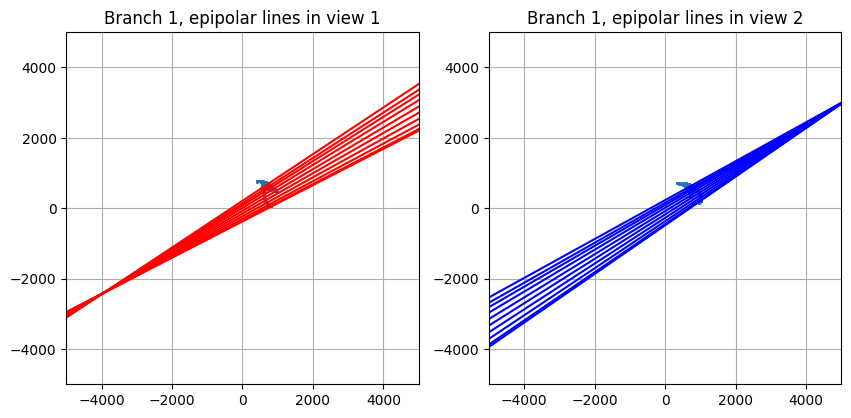

In [60]:
"""
FIGURE SETUP, DO NOT TOUCH
"""
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].set_title("Branch 1, epipolar lines in view 1")
ax[1].set_title("Branch 1, epipolar lines in view 2")

for a in [ax[0], ax[1]]:
    a.set_aspect('equal', adjustable='box') # ? Set the aspect ratio
    a.grid() # ? Add the grid
    a.set_xlim(-5000, 5000) # ? Set the limits
    a.set_ylim(-5000, 5000)
"""
END OF FIGURE SETUP
"""

# TODO : Sample view 1
sampled_view_1, sampled_view_1_labels = [], []
for branch_idx in np.unique(mesh.skeleton_labels): # ? For each branch idx
    pts = view_1_pts_2d[mesh.skeleton_labels == branch_idx] # ? Select the corresponding points (ie. where the label of the point corresponds to the branch_idx)
    # TODO : double the point density for each branch, then use the interpolation function to... interpolate. Don't forget to also save the labels of your newly created points !
    re_x = lab_2.utils.interpolate(pts, len(pts) * 2)
    sampled_view_1.extend(re_x)
    sampled_view_1_labels.extend([branch_idx] * len(re_x))

sampled_view_1 = np.array(sampled_view_1)
sampled_view_1_labels = np.array(sampled_view_1_labels)
# TODO : Do the same thing for view 2
# YOUR CODE GOES HERE
sampled_view_2, sampled_view_2_labels = [], []
for branch_idx in np.unique(mesh.skeleton_labels):
    pts = view_2_pts_2d[mesh.skeleton_labels == branch_idx] # ? Select the corresponding points (ie. where the label of the point corresponds to the branch_idx)
    # TODO : double the point density for each branch, then use the interpolation function to... interpolate. Don't forget to also save the labels of your newly created points !
    re_x = lab_2.utils.interpolate(pts, len(pts) * 2)
    sampled_view_2.extend(re_x)
    sampled_view_2_labels.extend([branch_idx] * len(re_x))
sampled_view_2 = np.array(sampled_view_2)
sampled_view_2_labels = np.array(sampled_view_2_labels)

# ? Now we find the matching points
"""
For each point in view 1 :
    - compute the epipolar lines using the fundamental matrix.
    - then find the closest point to the epipolar line in resampled view 2
    - store that pair (point_v1, point_v2_resampled) : you just did epipolar matching !

Now plot a few epipolar lines on the first branch in both views. Use the predefined limits (-5000, 5000) setup in the beginning of this code cell.
"""
# TODO : YOUR CODE GOES HERE

pairs_view_12 = []
epi_lines_2 = []
for i in range(len(view_1_pts_2d)):
    dist = []
    epi_line =  np.array([view_1_pts_2d[i][0], view_1_pts_2d[i][1], 1]) @ F
    epi_lines_2.append(epi_line)
    # closest line finding
    subsample = sampled_view_2[sampled_view_2_labels == mesh.skeleton_labels[i]]
    for j in range(len(subsample)):
        dist.append(distance_point_to_line(epi_line, subsample[j]))
    min_dist = np.argmin(dist)
    pairs_view_12.append([view_1_pts_2d[i], subsample[min_dist]])

pairs_view_21 = []
epi_lines_1 = []
for i in range(len(view_2_pts_2d)):
    dist = []
    epi_line = F @ np.array([view_2_pts_2d[i][0], view_2_pts_2d[i][1], 1])
    epi_lines_1.append(epi_line)
    subsample = sampled_view_1[sampled_view_1_labels == mesh.skeleton_labels[i]]
    for j in range(len(subsample)):
        dist.append(distance_point_to_line(epi_line, subsample[j]))
    min_dist = np.argmin(dist)
    pairs_view_21.append([view_2_pts_2d[i], subsample[min_dist]])
pairs_view_21 = np.array(pairs_view_21)
pairs_view_12 = np.array(pairs_view_12)

epi_lines_1 = np.array(epi_lines_1)
epi_lines_2 = np.array(epi_lines_2)
pts = view_2_pts_2d[mesh.skeleton_labels == 0]
loc = len(pts) // 10
locs = np.arange(10)
locs_1 = locs * loc

pts = view_1_pts_2d[mesh.skeleton_labels == 0]
loc = len(pts) // 10
locs = np.arange(10)
locs_2 = locs * loc

sample_lines_1 = np.array(epi_lines_1)[locs_1]
sample_lines_2 = np.array(epi_lines_2)[locs_2]

x = np.linspace(-5000, 5000, 10000)
for i in range(len(sample_lines_1)):
    ax[0].plot(x, -(sample_lines_2[i,2] + sample_lines_2[i,0]*x)/sample_lines_2[i,1], color='red')
    ax[1].plot(x, -(sample_lines_1[i,2] + sample_lines_1[i,0]*x)/sample_lines_1[i,1], color='blue')

ax[0].scatter(view_1_pts_2d[:,0], view_1_pts_2d[:,1], s=1)
ax[1].scatter(view_2_pts_2d[:,0], view_2_pts_2d[:,1], s=1)

plt.show()
plt.close()

In [61]:
print(pairs_view_12.shape)

(658, 2, 2)


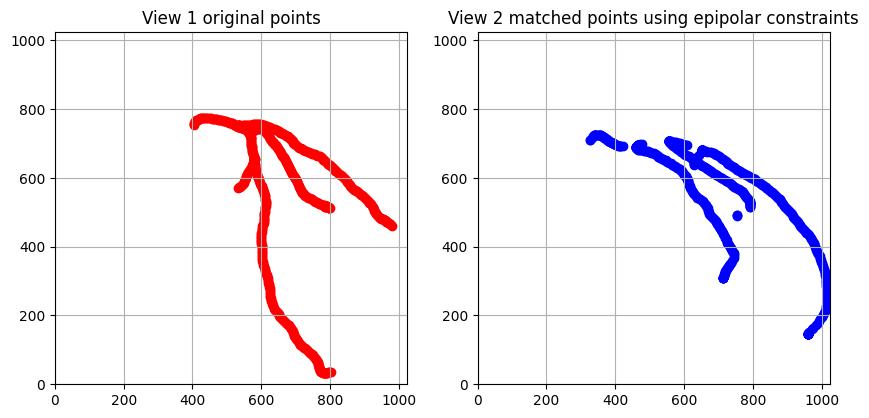

In [62]:

"""
FIGURE SETUP, DO NOT TOUCH
"""
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].set_title("View 1 original points")
ax[1].set_title("View 2 matched points using epipolar constraints")

for a in [ax[0], ax[1]]:
    a.set_aspect('equal', adjustable='box')
    a.grid()
    a.set_xlim(0, image_size)
    a.set_ylim(0, image_size)
"""
END OF FIGURE SETUP
"""
ax[0].scatter(pairs_view_12[:,0,0], pairs_view_12[:,0,1], c='red')
"""matched_1_in_view2 = []
matched_2_in_view1 = []
for i in range(len(view_1_pts_2d)):
    matched_1_in_view2.append([-(epi_lines_1[i,2] + epi_lines_1[i,1]*sampled_view_1[i,1])/epi_lines_1[i, 0], sampled_view_1_labels[i]])
    matched_2_in_view1.append([-(epi_lines_2[i,2] + epi_lines_2[i,1]*sampled_view_2[i,1])/epi_lines_2[i,0], sampled_view_2_labels[i]])

matched_2_in_view1 = np.array(matched_2_in_view1)
matched_1_in_view2 = np.array(matched_1_in_view2)"""
ax[1].scatter(pairs_view_12[:,1,0], pairs_view_12[:,1,1], c='blue')
plt.show()

# Question 3
In the case of a stereoscopic system that is not fully calibrated, calculating a depth map can
provide a first approximation of the 3D shape of an object in the scene. In this question, you will
construct such a depth map and compare it to the real 3D structure of the coronary tree.
Construct the depth map of the vessel central lines with the following steps:
1) Compute the disparity between the pairs of corresponding points obtained in Question 2
2) Compute the depth Z at each point in View 1

Next, construct another version of the depth map, by first rectifying the two images (using the
provided function), recalculating the disparities between point pairs and recalculating the Z map.  

Display as 2D figures with color maps: first the disparity maps, then the depth maps in each case.  

Now, construct the real (ground truth) depth map of the vessels skeleton. To do this, you must
first use the known geometric system parameters to transform the reference model to the
coordinate frame of the 1st source. Consider the Z coordinates of the transformed model as the
depth map. Display this depth map similarly to the previous ones.  

Compare the different figures (maps) obtained qualitatively (visually): do they make sense?  

When compared to the real depth map, which of the maps computed from disparities is most
similar to the ground truth? Discuss your results

In [63]:
print(mesh.skeleton.shape)

(658, 3)


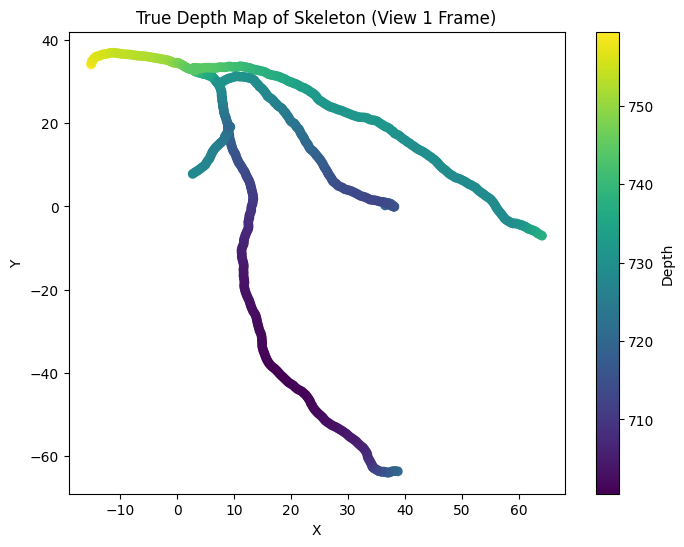

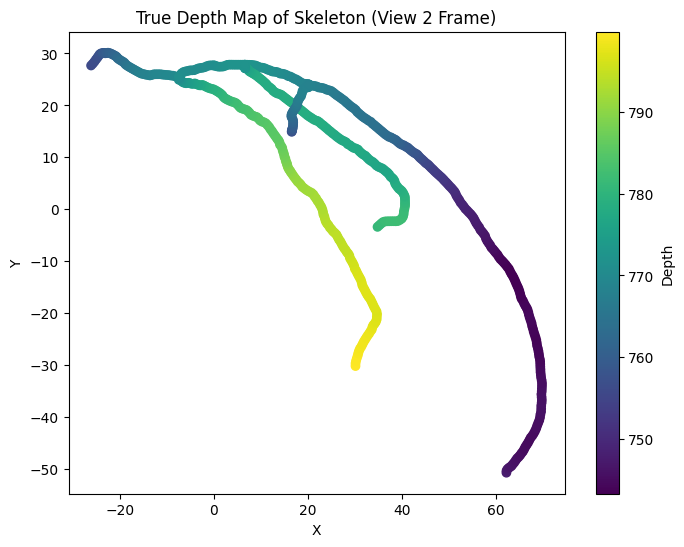

In [64]:
# ? Show the reference depth map
R = params_1['source']['R']  # Rotation matrix (3x3)
T = params_1['source']['T'].reshape(3)  # Translation vector (3,)

transformed = (R@mesh.skeleton.T).T + T

true_depth_map1 = transformed[:, 2]
plt.figure(figsize=(8, 6))
sc = plt.scatter(transformed[:, 0], transformed[:, 1], c=true_depth_map1, cmap='viridis')
plt.colorbar(sc, label='Depth')
plt.title("True Depth Map of Skeleton (View 1 Frame)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

R = params_2['source']['R']  # Rotation matrix (3x3)
T = params_2['source']['T'].reshape(3)  # Translation vector (3,)

transformed = (R@mesh.skeleton.T).T + T

true_depth_map2 = transformed[:, 2]
plt.figure(figsize=(8, 6))
sc = plt.scatter(transformed[:, 0], transformed[:, 1], c=true_depth_map2, cmap='viridis')
plt.colorbar(sc, label='Depth')
plt.title("True Depth Map of Skeleton (View 2 Frame)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [65]:
def compute_disparity(points_0:np.ndarray, points_1:np.ndarray) -> np.ndarray:
    """
    Computes disparity

    Parameters
    ----------
    points_0 : np.ndarray
        Points in first view, shape (N, 2)
    points_1 : np.ndarray
        Points in second view, shape (N, 2)

    Returns
    -------
    np.ndarray
        Disparity per point, shape (N, )
    """
    return np.linalg.norm(points_0 - points_1, axis=1)

def compute_depth(disparities:np.ndarray, f:float, b:float) -> np.ndarray:
    """
    Computes depth using disparity measurement

    Parameters
    ----------
    disparities : np.ndarray
        Disparity measurement, shape (N, )
    f : float
        Focal length of the camera
    b : float
        Distance between the two cameras

    Returns
    -------
    np.ndarray
        Depth associated to each point in disparity map, shape (N, )
    """
    return (f * b)/disparities

# TODO : print B, correlation metrics between real depth and estimated depth
# TODO : display both views (1 and matched points in 2), and for each view add the disparity map and the depth map. That's a total of 6 figures
T1 = params_1['source']['world_position'].flatten()
T2 = params_2['source']['world_position'].flatten()
b = np.linalg.norm(T2 - T1)
f = params_1["source"]["f"]

disparities = compute_disparity(pairs_view_12[:,0,:], pairs_view_12[:,1,:])
estimated_depths = compute_depth(disparities, f, b)
corr_coef = np.corrcoef(true_depth_map1, estimated_depths)[0,1]

print("b = ", b)
print("Correlation Coefficient between real depth and estimated depth : ", corr_coef)


b =  1064.9819353295518
Correlation Coefficient between real depth and estimated depth :  -0.039558013790104624


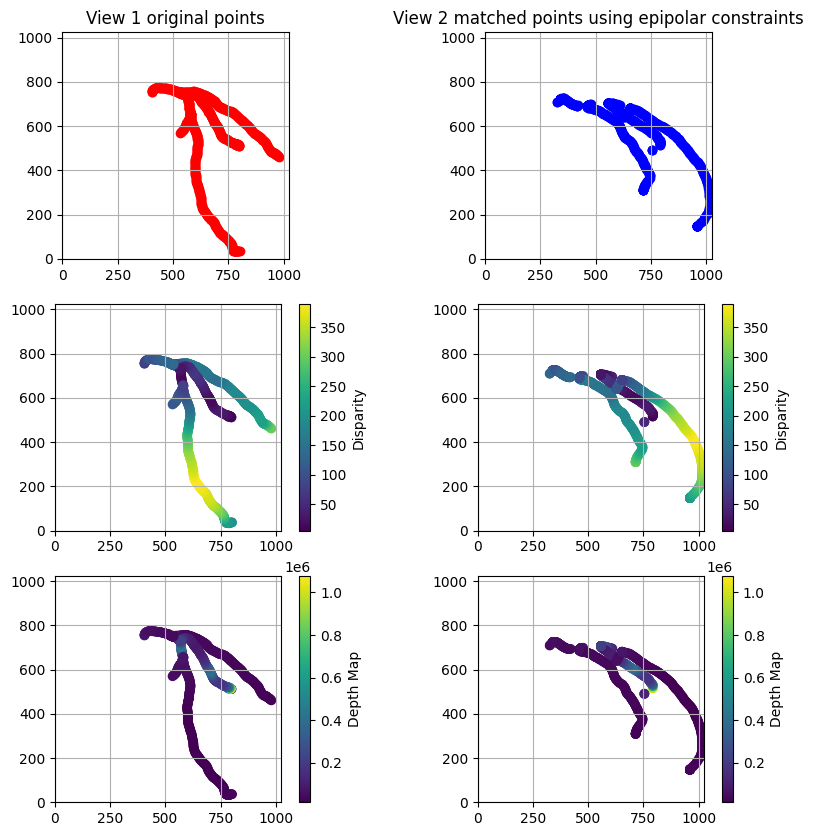

In [66]:
fig, ax = plt.subplots(3, 2, figsize = (10, 10))
ax[0,0].set_title("View 1 original points")
ax[0,1].set_title("View 2 matched points using epipolar constraints")

for a in [ax[0,0], ax[0,1], ax[1,0], ax[1,1], ax[2,0], ax[2,1]]:
    a.set_aspect('equal', adjustable='box')
    a.grid()
    a.set_xlim(0, image_size)
    a.set_ylim(0, image_size)
"""
END OF FIGURE SETUP
"""
ax[0,0].scatter(pairs_view_12[:,0,0], pairs_view_12[:,0,1], c='red')

ax[0,1].scatter(pairs_view_12[:,1,0], pairs_view_12[:,1,1], c='blue')
disp_1 = ax[1,0].scatter(pairs_view_12[:,0,0], pairs_view_12[:,0,1], c=disparities, cmap='viridis')
fig.colorbar(disp_1, ax=ax[1,0], label='Disparity')
#ax[1,0].title("Reference Disparity Map of Skeleton (View 1 Frame)")
disp_2 = ax[1,1].scatter(pairs_view_12[:,1,0], pairs_view_12[:,1,1], c=disparities, cmap='viridis')
fig.colorbar(disp_2, ax=ax[1,1], label='Disparity')
#ax[1,1].title("Reference Disparity Map of Skeleton (View 1 Frame)")
depth_1 = ax[2,0].scatter(pairs_view_12[:,0,0], pairs_view_12[:,0,1], c=estimated_depths, cmap='viridis')
fig.colorbar(depth_1, ax=ax[2,0], label='Depth Map')
#ax[1,0].title("Reference Disparity Map of Skeleton (View 1 Frame)")
depth_2 = ax[2,1].scatter(pairs_view_12[:,1,0], pairs_view_12[:,1,1], c=estimated_depths, cmap='viridis')
fig.colorbar(depth_2, ax=ax[2,1], label='Depth Map')
plt.show()


In [67]:
T0, T1, new_P0, new_P1 = lab_2.geometry.rectify(params_1['source']['P'], params_2['source']['P']) # TODO : calculate transformation matrices and rectified projection matrices for both views using lab_2.utils.rectify

In [68]:
print(T0.shape)
print(new_P0.shape )
print(pairs_view_12[:,0,:].shape)
print(pairs_view_12.shape)

#pairs_view_12 = np.concatenate((pairs_view_12, np.ones((658, 2, 1))), axis=2)

(3, 3)
(3, 4)
(658, 2)
(658, 2, 2)


In [69]:
test = calculate_2d_projection(mesh.skeleton, new_P0)
print(test.shape)
homo1 = lab_2.geometry.to_homogeneous(pairs_view_12[:,0,:])
homo2 = lab_2.geometry.to_homogeneous(pairs_view_12[:,1,:])
print(pairs_view_12.shape)
print(homo1.shape)
print(homo2.shape)

(658, 2)
(658, 2, 2)
(658, 3)
(658, 3)


In [70]:
 # TODO : apply transformation matrix to view 1 points
pts_2d_view_1_rectif = homo1 @ T0.T
pts_2d_view_2_rectif = homo2 @ T1.T # TODO : apply transformation matrix to view 2 sampled points

pts_2d_view_1_rectif = pts_2d_view_1_rectif[:,:2].T / pts_2d_view_1_rectif[:,2]
pts_2d_view_2_rectif = pts_2d_view_2_rectif[:,:2].T / pts_2d_view_2_rectif[:,2]
print(pts_2d_view_1_rectif.shape)
print(pts_2d_view_2_rectif.shape)

(2, 658)
(2, 658)


In [71]:
# TODO : match epipolar lines between the rectified views (hint : what are the epippolar lines equations now that the views are rectified ?)
print(pts_2d_view_2_rectif.shape)

(2, 658)


In [72]:
# TODO : print B, correlation metrics between real depth and estimated depth
# TODO : display both views (1 rectified and matched points in 2 rectified), and for each view add the disparity map and the depth map. That's a total of 6 figures
T1 = params_1['source']['world_position'].flatten()
T2 = params_2['source']['world_position'].flatten()
b = np.linalg.norm(T2 - T1)
f = params_1["source"]["f"]

disparities = compute_disparity(pts_2d_view_1_rectif.T, pts_2d_view_2_rectif.T)
estimated_depths = compute_depth(disparities, f, b)
print(true_depth_map1.shape)
print(estimated_depths.shape)
print(pts_2d_view_1_rectif.shape)
corr_coef = np.corrcoef(true_depth_map1, estimated_depths)[0,1]

print("b = ", b)
print("Correlation Coefficient between real depth and estimated depth : ", corr_coef)

(658,)
(658,)
(2, 658)
b =  1064.9819353295518
Correlation Coefficient between real depth and estimated depth :  0.8606539866787282


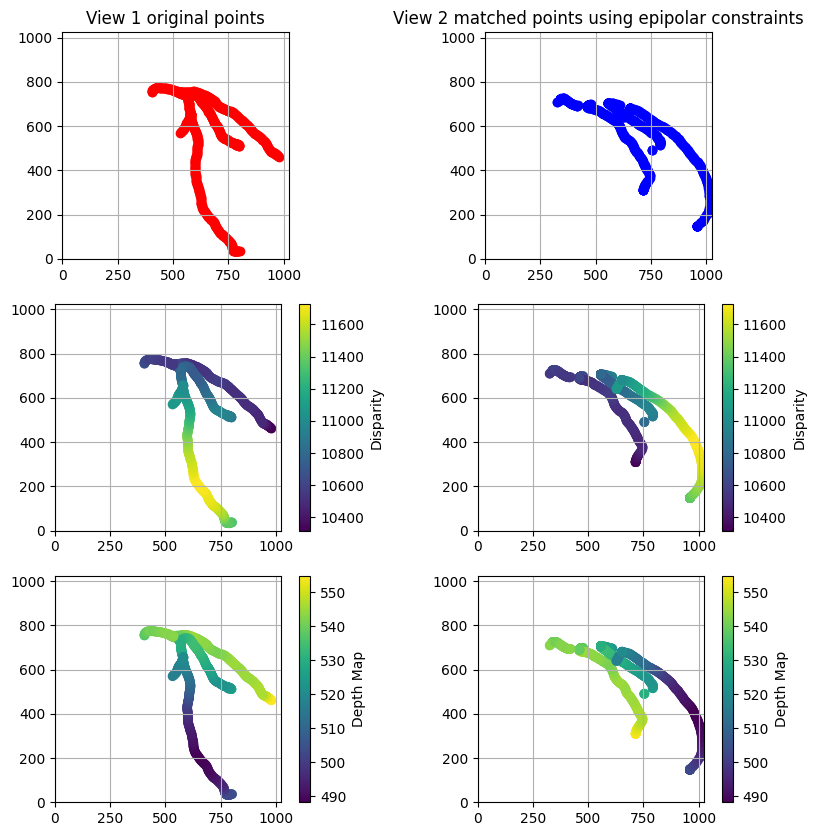

In [73]:
fig, ax = plt.subplots(3, 2, figsize = (10, 10))
ax[0,0].set_title("View 1 original points")
ax[0,1].set_title("View 2 matched points using epipolar constraints")

for a in [ax[0,0], ax[0,1], ax[1,0], ax[1,1], ax[2,0], ax[2,1]]:
    a.set_aspect('equal', adjustable='box')
    a.grid()
    a.set_xlim(0, image_size)
    a.set_ylim(0, image_size)
"""
END OF FIGURE SETUP
"""
ax[0,0].scatter(pairs_view_12[:,0,0], pairs_view_12[:,0,1], c='red')

ax[0,1].scatter(pairs_view_12[:,1,0], pairs_view_12[:,1,1], c='blue')
disp_1 = ax[1,0].scatter(pairs_view_12[:,0,0], pairs_view_12[:,0,1], c=disparities, cmap='viridis')
fig.colorbar(disp_1, ax=ax[1,0], label='Disparity')
#ax[1,0].title("Reference Disparity Map of Skeleton (View 1 Frame)")
disp_2 = ax[1,1].scatter(pairs_view_12[:,1,0], pairs_view_12[:,1,1], c=disparities, cmap='viridis')
fig.colorbar(disp_2, ax=ax[1,1], label='Disparity')
#ax[1,1].title("Reference Disparity Map of Skeleton (View 1 Frame)")
depth_1 = ax[2,0].scatter(pairs_view_12[:,0,0], pairs_view_12[:,0,1], c=estimated_depths, cmap='viridis')
fig.colorbar(depth_1, ax=ax[2,0], label='Depth Map')
#ax[1,0].title("Reference Disparity Map of Skeleton (View 1 Frame)")
depth_2 = ax[2,1].scatter(pairs_view_12[:,1,0], pairs_view_12[:,1,1], c=estimated_depths, cmap='viridis')
fig.colorbar(depth_2, ax=ax[2,1], label='Depth Map')
plt.show()


In [74]:
# Getting the RMSE to compare the two maps
RMSE = np.sqrt(np.mean((true_depth_map1 - estimated_depths)**2))
print(RMSE)

199.06986804553782


# Question 4

In [75]:
# TODO : Calculate the DLT coefficients (think about their meaning, you already have them, just in the wrong shape)
# DLT coefficients are the projection matrices
print(new_P0.shape)
print(new_P0)
dlt_v1 = params_1['source']['P'].flatten()[:11] / params_1['source']['P'].flatten()[11]
dlt_v2 = params_2['source']['P'].flatten()[:11] / params_2['source']['P'].flatten()[11]

(3, 4)
[[-3.97643919e+03 -3.46510732e+03  1.16111257e+03  3.13327277e+06]
 [ 3.55930089e+03 -4.04803380e+03  3.34692764e+02  2.70418106e+05]
 [ 1.13047017e-01  5.49419340e-02  9.92069431e-01  5.28160363e+02]]


In [76]:
reconstruction_3d_DLT = [lab_2.geometry.calculate_3d_point(pairs_view_12[i,0,0], pairs_view_12[i,0,1], pairs_view_12[i,1,0], pairs_view_12[i,1,1], dlt_v1, dlt_v2) for i in range(len(pairs_view_12))] # TODO : using the non rectified views (view 1 and matched points in sampled view 2), perform the DLT reconstruction using lab_2.geometry.calculate_3d_point
reconstruction_3d_DLT = np.array(reconstruction_3d_DLT)
print(reconstruction_3d_DLT.shape)

(658, 3)


In [77]:
fig = go.Figure(layout=go.Layout(
            scene=dict(
                aspectmode='data'
            )
        ))

fig.add_trace(
            go.Scatter3d(
                x=reconstruction_3d_DLT[:, 0],
                y=reconstruction_3d_DLT[:, 1],
                z=reconstruction_3d_DLT[:, 2],
                mode='markers',
                marker={'size': 2}
            )
        )

fig.show()

In [91]:
# ? View the figure

print("There existed a problem in the matching due to there being multiple points from different branches on the epipolar line, messing up the correspondance\\This has since been fixed but write in the report")
"""pc = lab_2.structures.Pointcloud(reconstruction_3d_DLT)
mesh.plot_compare(pc)"""
pc = lab_2.structures.Pointcloud(reconstruction_3d_DLT)
mesh.plot_compare(pc)

There existed a problem in the matching due to there being multiple points from different branches on the epipolar line, messing up the correspondance\This has since been fixed but write in the report


In [79]:
# ? 3D RMS error:
print('RMS for the DLT reconstruction:', lab_2.metrics.rms(mesh.skeleton, pc.vertices))

RMS for the DLT reconstruction: 3.518634709599588


In [88]:
# TODO : perform the back reprojection of `reconstruction_3d_DLT` and measure the error compared to the ground truth
reproj_v1 = lab_2.geometry.to_homogeneous(reconstruction_3d_DLT) @ params_1['source']['P'].T
reproj_v2 = lab_2.geometry.to_homogeneous(reconstruction_3d_DLT) @ params_2['source']['P'].T

reproj_v1 = reproj_v1[:,:2].T / reproj_v1[:,2]
reproj_v2 = reproj_v2[:,:2].T / reproj_v2[:,2]

print('RMS for the back reprojection:', lab_2.metrics.rms(calculate_2d_projection(mesh.skeleton, params_1['source']['P']), reproj_v1.T))
print('RMS for the back reprojection:', lab_2.metrics.rms(calculate_2d_projection(mesh.skeleton, params_2['source']['P']), reproj_v2.T))
print(f"Reconstruction back to view 2 being worse makes sense because we are using the sampled points in view 2 while view 1 is true")

RMS for the back reprojection: 11.660737082781209
RMS for the back reprojection: 24.615119774206267
Reconstruction back to view 2 being worse makes sense because we are using the sampled points in view 2 while view 1 is true


In [85]:
def add_noise(parameter:float, percentage:float) -> float:
    """
    Adds uniform-sampled noise to the original parameter with respect to its primary value

    Parameters
    ----------
    parameter : float
        Parameter original value
    percentage : float
        Amplitude of the noise

    Returns
    -------
    float
        Modified parameter value
    """
    # TODO : sample the noise correctly
    noise = np.random.uniform(-0.5*percentage, 0.5*percentage)
    return float(parameter + noise)

# TODO : add up to 10% noise, and measure RMS everytime, then plot it

# Question 5

In [ ]:
# TODO : add up to 10% noise, and measure RMS everytime AFTER SELF CALIBRATION, then plot it. You should see something different compared to the previous question.

In [ ]:
# TODO : For each parameter (SID, SOD, alpha_0, beta_0, alpha_1, beta_1), display a bar chart that, for every level of noise, compares the noisy value to the refined one (after self calibration). Display the reference value as a horizontal line